loaded 1 existing images from dataset
loaded 1 existing weights from weights-minTrue-r20v2


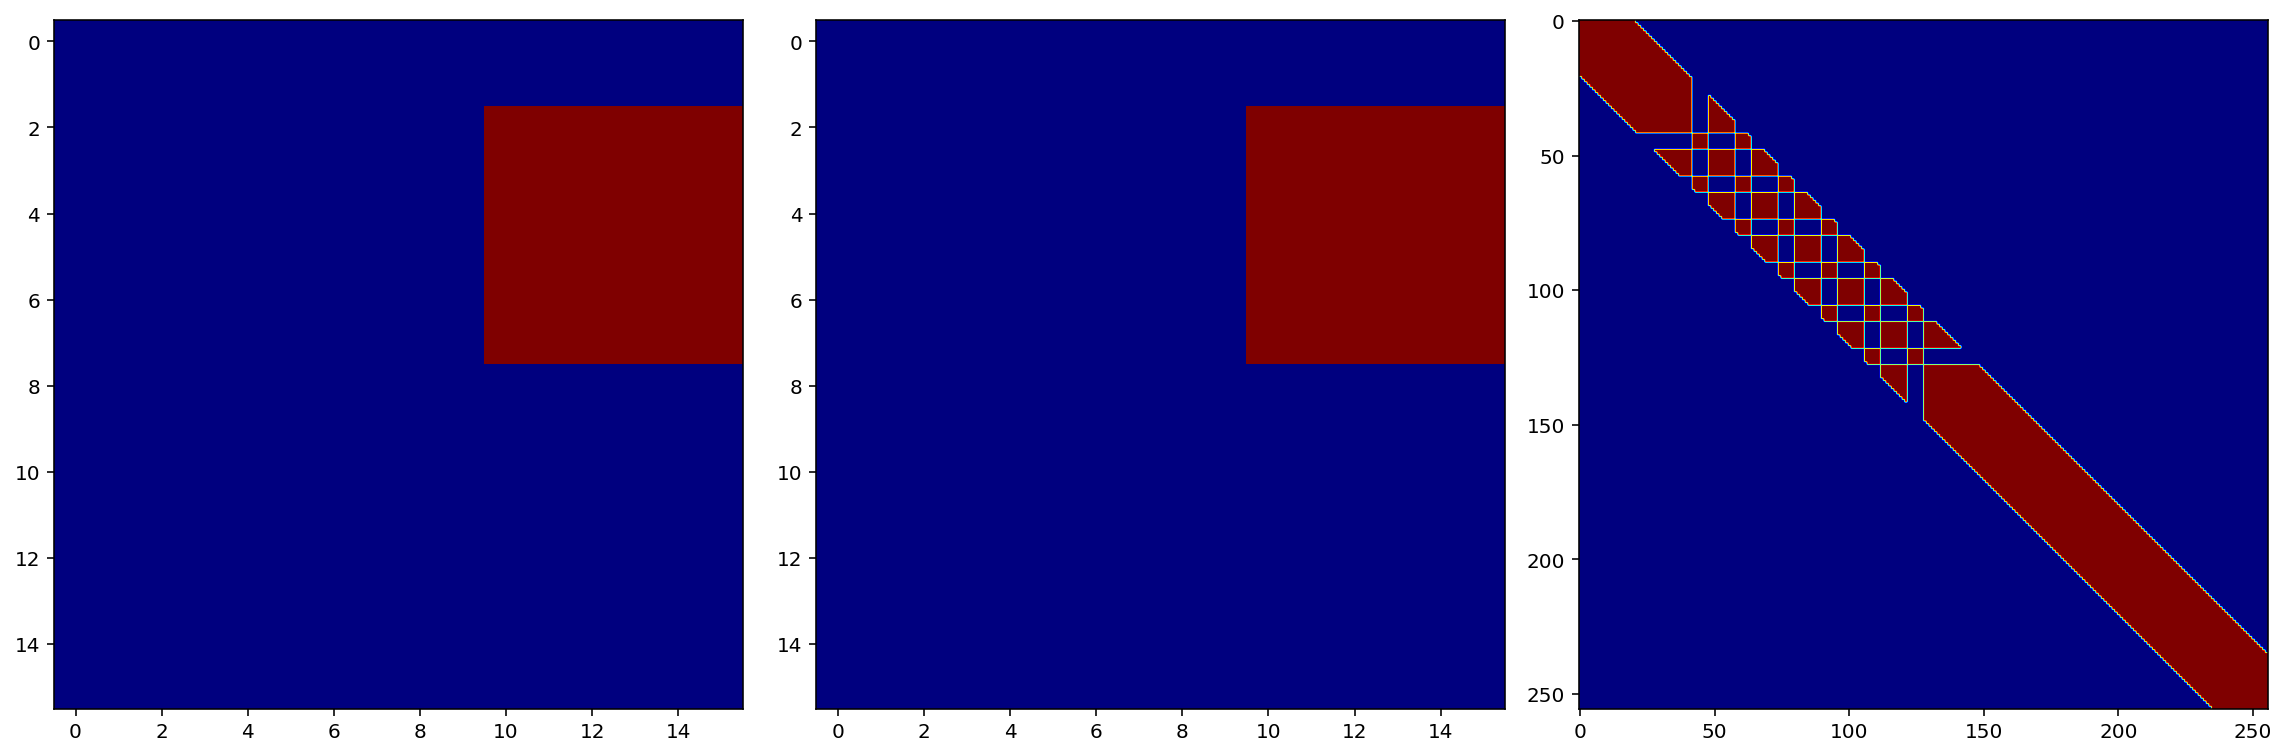

In [1]:
# THE DATA PORTION
# load a sample, see how it looks

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from net_argparser import net_argparser
from data import *

args = net_argparser(ipynb=True)
args.network = 1
args.total_images = 1
args.minify = True
args.radius = 20
args.img_size = [16,16] # the default is 32,32 anyway

train_dataset = SimpleDatasets(args, transform=transforms.ToTensor())
row = [train_dataset.get_image(0), train_dataset.get_segmentation(0), de_minW(train_dataset.get_weights(0))]

plot_multiple_images(0, row, figsize=args.img_size, ipynb=True, cmap_name='jet')

In [2]:
# # try it without using the existing NC node
# # TODO: fix

# import torch

# def distance_matrix(mat):
#     d= ((mat.unsqueeze (0)-mat.unsqueeze (1))**2).sum(2)**0.5
#     return d

# # from https://github.com/dimkastan/PyTorch-Spectral-clustering/blob/master/FiedlerVectorLaplacian.py
# # x is the adjacency matrix
# x = row[2]
# x = x.squeeze()
# print(x.shape)

# input = row[0]
# test_d = distance_matrix(input)

# D = x.sum(0).diag() # degree matrix
# L = D - x.float() # laplacian
# print(f'D,x {D.shape}, {x.shape}')
# Lsym=torch.mm(torch.mm(torch.diag(torch.pow(torch.diag(D),-0.5)),L),torch.diag(torch.pow(torch.diag(D),-0.5))) # symmetric laplacian

# [u,s,v]=torch.svd(Lsym)

# y = u[:,-2]
# y = y.view(1,1, args.img_size[0], args.img_size[1]) 

# plot_images = [y, row[1], x[None,None,:,:], Lsym[None,None,:,:]]
# plot_multiple_images(0, plot_images, figsize=args.img_size, ipynb=True, cmap_name='jet')

shapes
pre A torch.Size([1, 20, 256]), torch.Size([20, 256])
post A torch.Size([1, 256, 256]), torch.Size([256, 256])
d torch.Size([1, 256]), torch.Size([256])
D torch.Size([1, 256, 256]), torch.Size([256, 256])
inv sqrt torch.Size([1, 256, 256]), torch.Size([256, 256])
L torch.Size([1, 256, 256]), torch.Size([256, 256])
Lsym torch.Size([1, 256, 256]), torch.Size([256, 256])
v,i,u torch.Size([1, 256, 256]), torch.Size([1, 256, 256]), torch.Size([256, 256])
dict_keys(['eigh_1_None', 'eigh_None_1', 'eigh_0_None', 'eigh_None_0', 'svd_1_None', 'svd_None_1', 'svd_0_None', 'svd_None_0'])


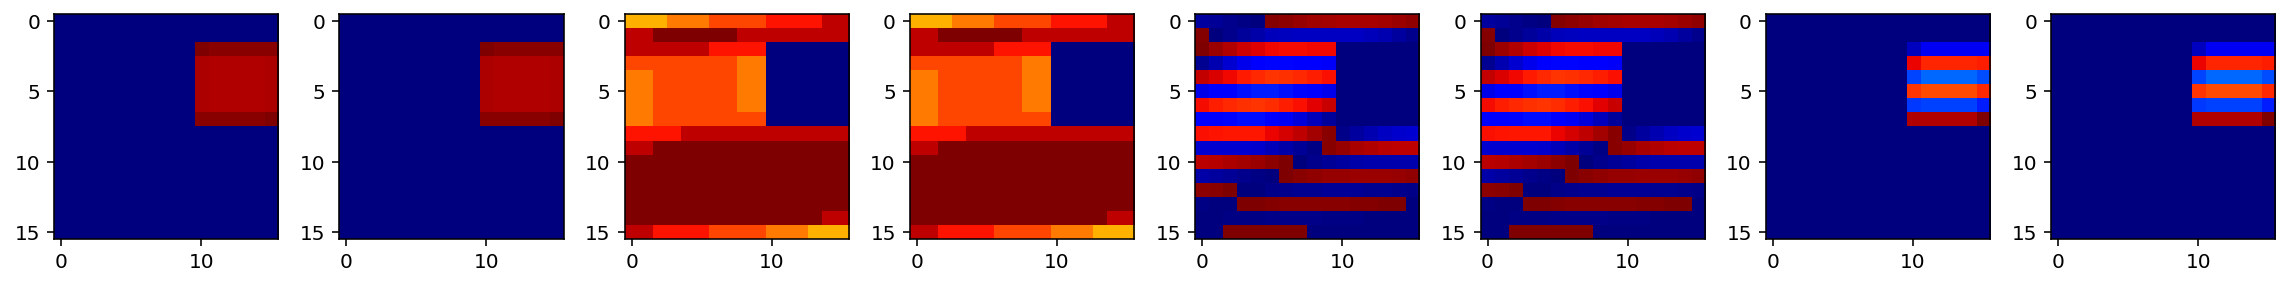

batch_y1 - Max: 0.0000, Min: -0.1783, Mean: -0.0233, Median: -0.0000, std var: 0.0581
batch_y0 - Max: 0.0730, Min: 0.0000, Mean: 0.0577, Median: 0.0675, std var: 0.0241
y_smol - Max: 0.0000, Min: -0.1783, Mean: -0.0233, Median: -0.0000, std var: 0.0581


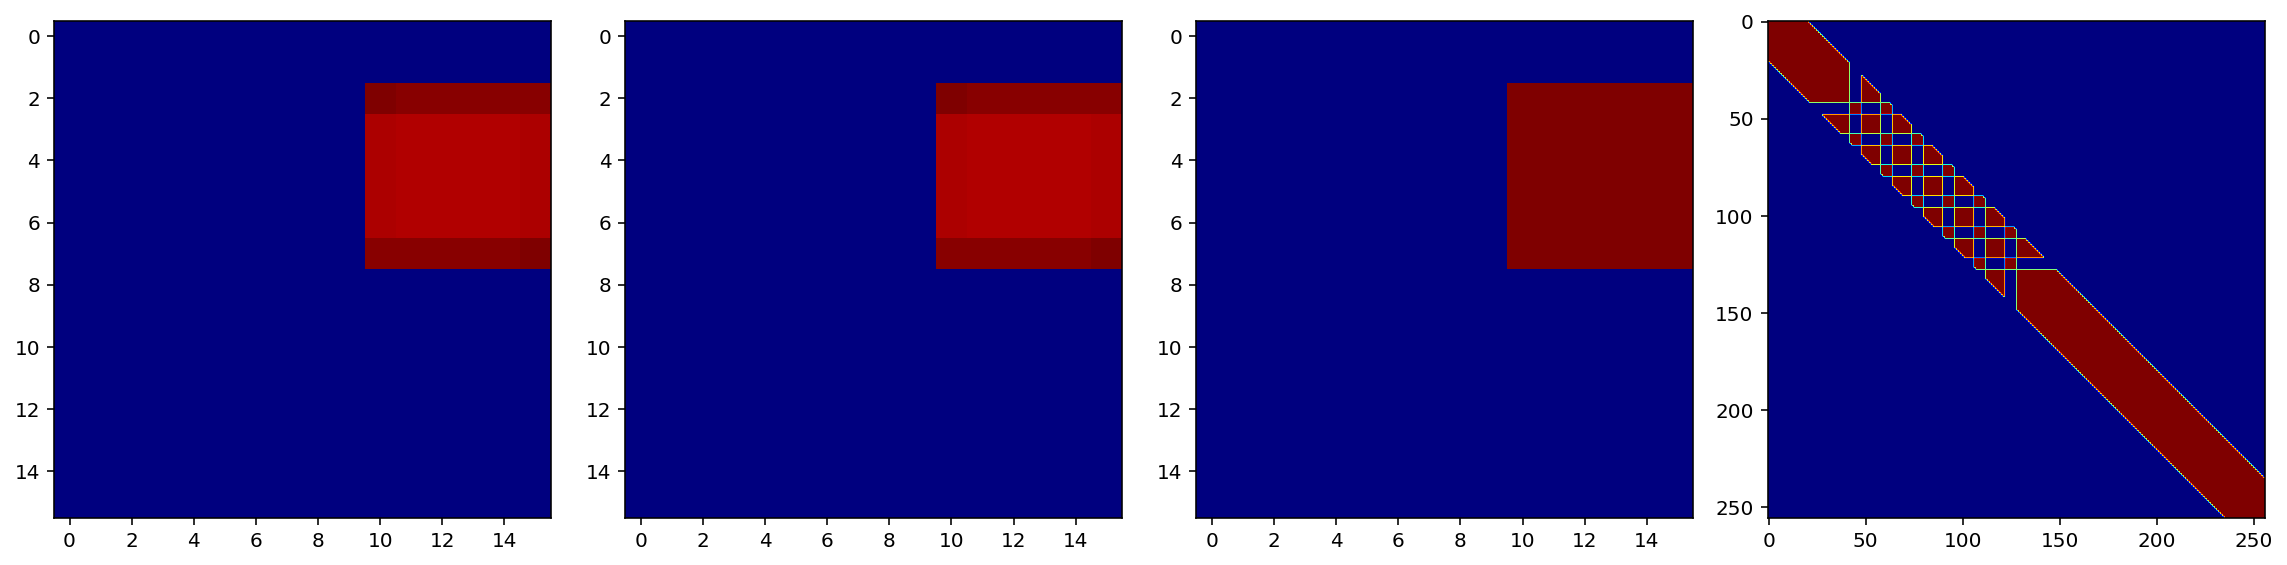

batch_y torch.Size([1, 16, 16]), y_smol torch.Size([16, 16])


AssertionError: eigenvector error

In [5]:
# test slowly verifying the einsums

A = train_dataset.get_weights(0)
A_smol = train_dataset.get_weights(0).squeeze()
print(f'shapes\npre A {A.shape}, {A_smol.shape}')
A = de_minW(train_dataset.get_weights(0))
A_smol = de_minW(train_dataset.get_weights(0)).squeeze()
print(f'post A {A.shape}, {A_smol.shape}')
assert torch.allclose(A.squeeze(), A_smol)

d = torch.einsum('bij->bj', A)
d_smol = A_smol.sum(0)
print(f'd {d.shape}, {d_smol.shape}')
assert torch.allclose(d.squeeze(), d_smol), "degree matrix error"

D = torch.diag_embed(d)
D_smol = torch.diag(d_smol)
print(f'D {D.shape}, {D_smol.shape}')
assert torch.allclose(D.squeeze(), D_smol), "diagonalising error"

D_inv_sqrt = torch.diag_embed(d).pow(-0.5) # was previously in the diag_embed, avoided inf values, but made it so they were different
D_inv_sqrt_2 = torch.diag_embed(d.pow(-0.5)) # NOTE: this is the same as using torch.mm(torch.diag(...)) with the reverse of these...
D_smol_inv_sqrt = torch.pow(torch.diag(d_smol),-0.5)
print(f'inv sqrt {D_inv_sqrt.shape}, {D_smol_inv_sqrt.shape}')
assert torch.allclose(D_inv_sqrt.squeeze(), D_smol_inv_sqrt) ,"inverse sqrt error"

L = D-A
L_smol = D_smol - A_smol
print(f'L {L.shape}, {L_smol.shape}')
# NOTE: requires matching sizes for D and A (so not minified A)
assert torch.allclose(L.squeeze(), L_smol) ,"laplacian error"

Lsym_smol = torch.mm(torch.mm(torch.diag(torch.pow(torch.diag(D_smol),-0.5)),L_smol),torch.diag(torch.pow(torch.diag(D_smol),-0.5)))
# Lsym_smol_2 = torch.mm(torch.mm(torch.diag(D_smol_inv_sqrt),L_smol),torch.diag(D_smol_inv_sqrt))
# assert torch.allclose(Lsym_smol, Lsym_smol_2) ,"smols different forms"
# RuntimeError: self must be a matrix
Lsym = torch.einsum('...ij,...jk->...ik', torch.einsum('...ij,...jk->...ik', D_inv_sqrt_2 , L) , D_inv_sqrt_2)
print(f'Lsym {Lsym.shape}, {Lsym_smol.shape}')
assert torch.allclose(Lsym.squeeze(), Lsym_smol) ,"Lsym error"

expected_y = train_dataset.get_segmentation(0)
channels,height,width = expected_y.shape
batchs = 1
output_size = (batchs, height, width)

# NC STYLE - needs to be fixed
(w, v) = torch.linalg.eigh(Lsym) # from my guess work
# num_eigs = 1
[i,j,k]=torch.svd(Lsym)

# brute force testing :)
# view to convert into the correct shape, None to not lose dimension and maintain overall shape structure b,c,x,y
eigs = {
    'eigh_1_None' : v[:,:,1,None].reshape(output_size),
    'eigh_None_1' : v[:,:,None,1].reshape(output_size),
    'eigh_0_None' : v[:,:,0,None].reshape(output_size),
    "eigh_None_0" : v[:,:,None,0].reshape(output_size),
    'svd_1_None'  : i[:,:,1,None].reshape(output_size),
    'svd_None_1'  : i[:,:,None,1].reshape(output_size),
    'svd_0_None'  : i[:,:,0,None].reshape(output_size),
    "svd_None_0"  : i[:,:,None,0].reshape(output_size),
}

# from https://github.com/dimkastan/PyTorch-Spectral-clustering/blob/master/FiedlerVectorLaplacian.py 
[u,s,v_2]=torch.svd(Lsym_smol)
y_smol = u[:,-2].reshape(height, width)

print(f'v,i,u {v.shape}, {i.shape}, {u.shape}')

# find the eig that matches?
# or the eig which matches the input enough?
print(eigs.keys())
for key,value in eigs.items():
    if torch.allclose(value.squeeze(), y_smol):
        print(key)

vals = list(eigs.values())
plot_multiple_images(0, vals, figsize=args.img_size, ipynb=True, cmap_name='jet')

batch_y = v[:,:,1,None].reshape(output_size) # second smallest eigenvector from eigh
batch_y0 = v[:,:,0,None].reshape(output_size)
print(f'batch_y1 - Max: {torch.max(batch_y):.4f}, Min: {torch.min(batch_y):.4f}, Mean: {torch.mean(batch_y):.4f}, Median: {torch.median(batch_y):.4f}, std var: {torch.std(batch_y):.4f}')
print(f'batch_y0 - Max: {torch.max(batch_y0):.4f}, Min: {torch.min(batch_y0):.4f}, Mean: {torch.mean(batch_y0):.4f}, Median: {torch.median(batch_y0):.4f}, std var: {torch.std(batch_y0):.4f}')
print(f'y_smol - Max: {torch.max(y_smol):.4f}, Min: {torch.min(y_smol):.4f}, Mean: {torch.mean(y_smol):.4f}, Median: {torch.median(y_smol):.4f}, std var: {torch.std(y_smol):.4f}')
# test_plots_1 = [(batch_y > 0).float(), (y_smol[None,:,:] > 0).float()]
# plot_multiple_images(0, test_plots_1, figsize=args.img_size, ipynb=True)

test_plots_2 = [batch_y, y_smol[None,:,:], expected_y, A]
plot_multiple_images(0, test_plots_2, figsize=args.img_size, ipynb=True, cmap_name='jet')
print(f'batch_y {batch_y.shape}, y_smol {y_smol.shape}')
assert torch.allclose(batch_y.squeeze(), y_smol) ,"eigenvector error"


output:torch.Size([1, 1, 16, 16]), expected:torch.Size([1, 16, 16]), weights:torch.Size([1, 256, 256])


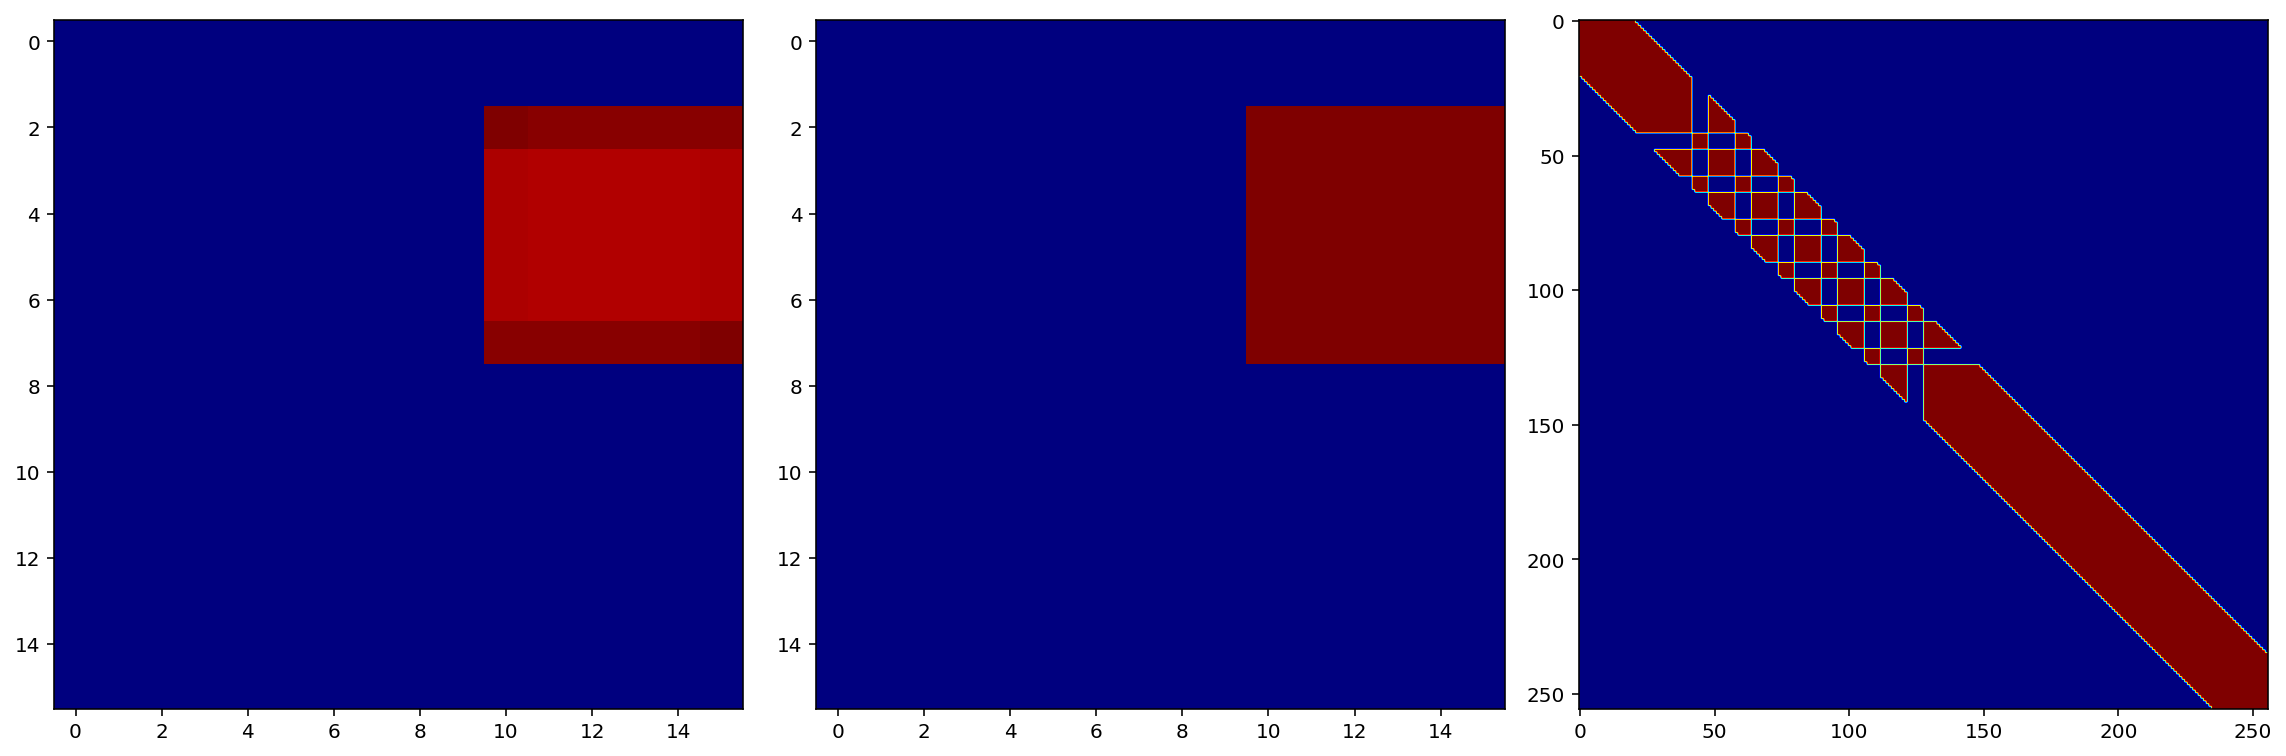

In [4]:
# The nc.py portion
# using the loaded data, see how it is segmented

from nc import NormalizedCuts
from node import DeclarativeLayer

nc = NormalizedCuts(eps=1) # check if eps value is correct, also test gamma for gradients..
decl = DeclarativeLayer(nc)

x = row[2] # gets the full rank matrix
y = decl(x) # as in model.py
y = y.view(y.size(0), 1, args.img_size[0], args.img_size[1]) # convert from NC node into this

plot_images = [y, row[1], x] # x,y, expected y (the 2nd index must always be the weights (expects one less dim))
print(f'output:{y.shape}, expected:{row[1].shape}, weights:{x.shape}')


plot_multiple_images(0, plot_images, figsize=args.img_size, ipynb=True, cmap_name='jet')